In [4]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, VGG19
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')#plotting styles

In [5]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])
#only for plotting^^^

In [6]:
# Load the data
df = pd.read_csv("archive/labels.csv")

In [7]:
# Map each id to its file name
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [8]:
df.describe()

id        count
count  2000.000000  2000.000000
mean   1000.500000    31.157500
std     577.494589     6.945417
min       1.000000    13.000000
25%     500.750000    26.000000
50%    1000.500000    31.000000
75%    1500.250000    36.000000
max    2000.000000    53.000000

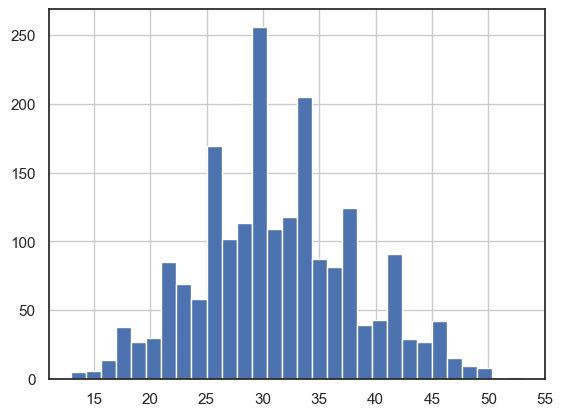

In [9]:
df['count'].hist(bins=30);

We are creating a larger dataset with the existing data, by modifying the given images slightly. So basically, we are flipping them, distorting color, vertically flipping them, but maintaining the same label info of their head count.

In [10]:
# Setup some constants
size = 224
batch_size = 64

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

In [12]:
flow_params = dict(
    dataframe=df,
    directory='archive/frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)
#The flow_from_dataframe method is particularly useful when working with large datasets that may not fit entirely into memory. It reads the data from the DataFrame, applies data augmentation and preprocessing defined in the datagen generator, and yields batches of augmented data during the training process. 

Found 1600 validated image filenames.
Found 400 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

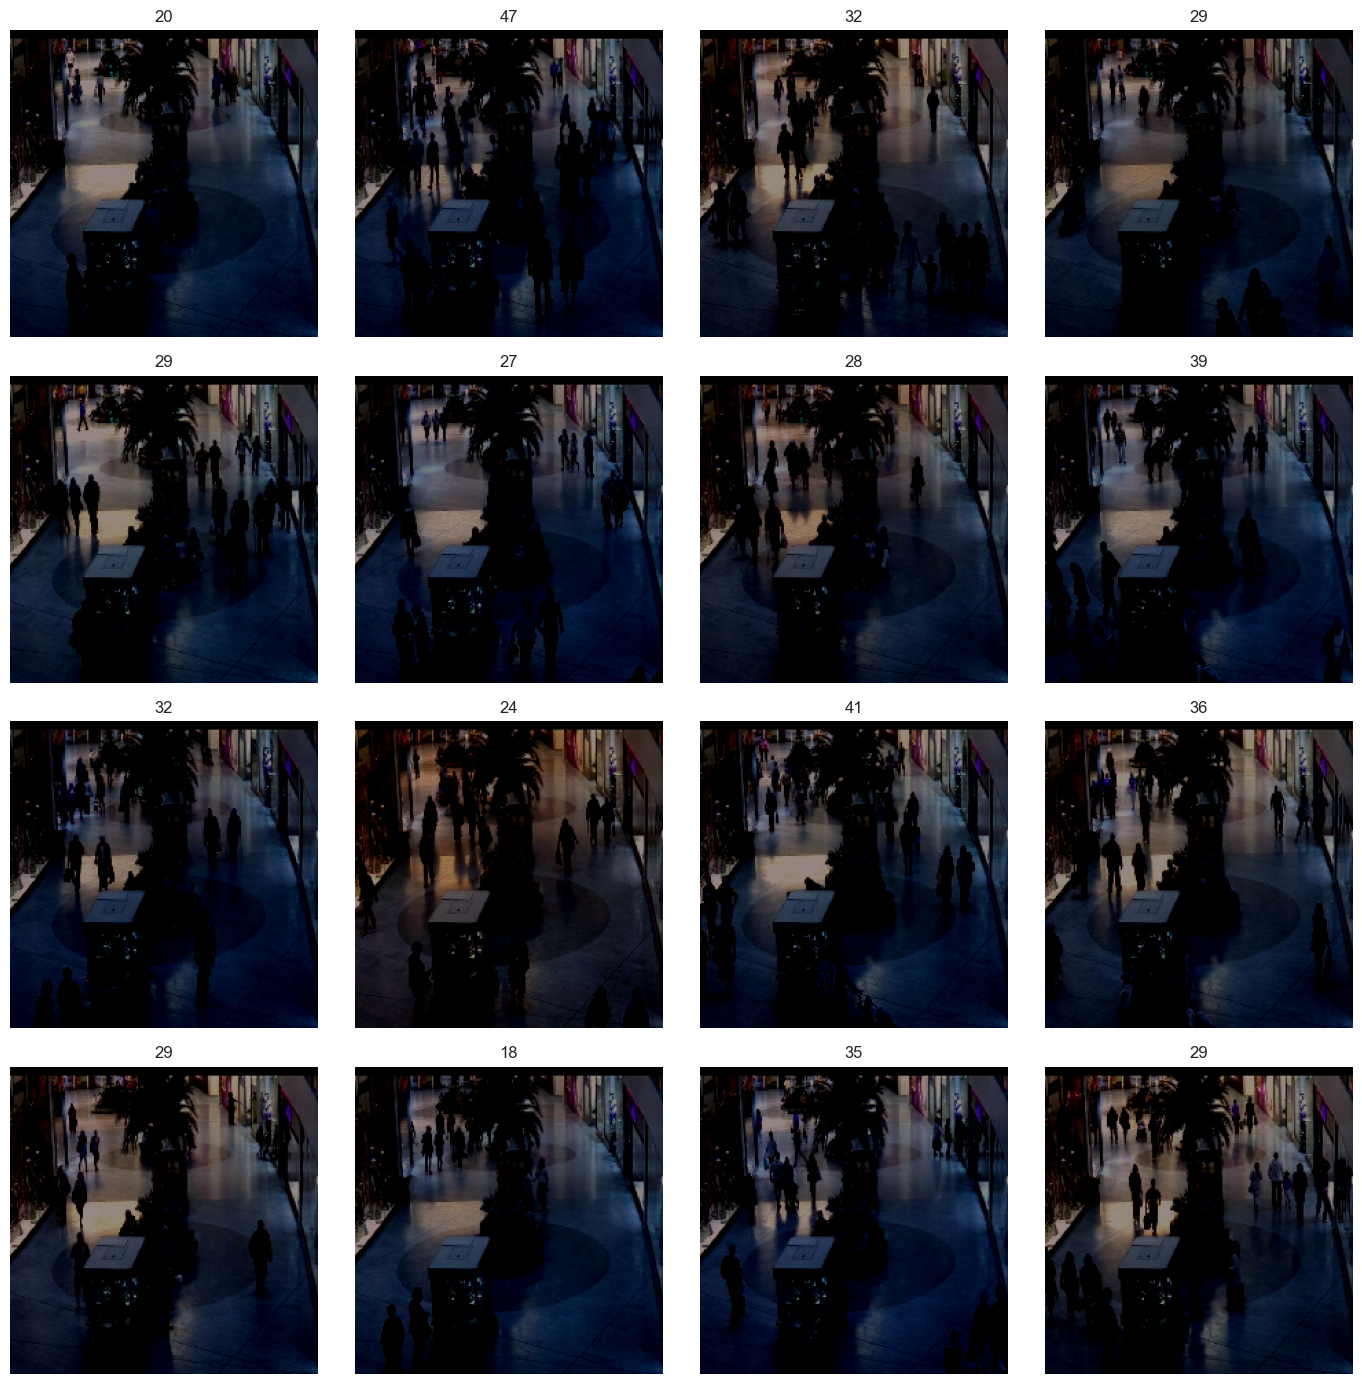

In [13]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.applications import ResNet50

weights_path = "/Users/dhevdharsan/Downloads/IOT_project/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5"

In [17]:
'''base_model1 = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need tomake the top custom.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so we used this.And 3 corresponds to the three color channels (RGB).
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)'''
base_model1 = ResNet50(
    weights=weights_path,
    include_top=False,
    input_shape=(size, size, 3),
    pooling='avg'
)

In [ ]:
# base_model.summary() you can un-comment this line to see the summary

In [18]:
# Here we edit the top (the last parts) of the network which was earlier disconnected ^^
x = base_model1.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
#This layer  is often referred to as the hidden layer, and it introduces non-linearity to the network.
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image


In [19]:
model1 = Model(inputs=base_model1.input, outputs=predictions)

In [20]:
k = -7
for layer in model1.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model1.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [21]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 3,153,921 (12.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

## 3.2 Set the optimizer and annealer

In [22]:
# Define the optimizer: this function will iteratively improve parameters in order to reduce the loss. 
optimizer = Adam(
    learning_rate=0.001,
    # Additional parameters that can be edited to increase accuracy:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [23]:
model1.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [24]:
# The LR is decreased dynamically when the score is not improved.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [29]:
# Fit the model
'''history1 = model1.fit_generator(
    generator=train_generator,
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)'''
history1 = model1.fit(
    x=train_generator,  # Use the training generator as input data
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)

print('\nDone.')

Epoch 1/50
25/25 - 150s - 6s/step - loss: 27.7258 - mean_absolute_error: 4.2340 - mean_squared_error: 27.7258 - val_loss: 270.6357 - val_mean_absolute_error: 15.6380 - val_mean_squared_error: 270.6357 - learning_rate: 0.0010
Epoch 2/50
25/25 - 148s - 6s/step - loss: 26.7859 - mean_absolute_error: 4.1689 - mean_squared_error: 26.7859 - val_loss: 171.7294 - val_mean_absolute_error: 12.1363 - val_mean_squared_error: 171.7294 - learning_rate: 0.0010
Epoch 3/50
25/25 - 157s - 6s/step - loss: 24.9321 - mean_absolute_error: 3.9962 - mean_squared_error: 24.9321 - val_loss: 48.7330 - val_mean_absolute_error: 5.7962 - val_mean_squared_error: 48.7330 - learning_rate: 0.0010
Epoch 4/50
25/25 - 170s - 7s/step - loss: 23.4773 - mean_absolute_error: 3.8946 - mean_squared_error: 23.4773 - val_loss: 60.3780 - val_mean_absolute_error: 6.5777 - val_mean_squared_error: 60.3780 - learning_rate: 0.0010
Epoch 5/50
25/25 - 145s - 6s/step - loss: 23.7968 - mean_absolute_error: 3.9067 - mean_squared_error: 23.7

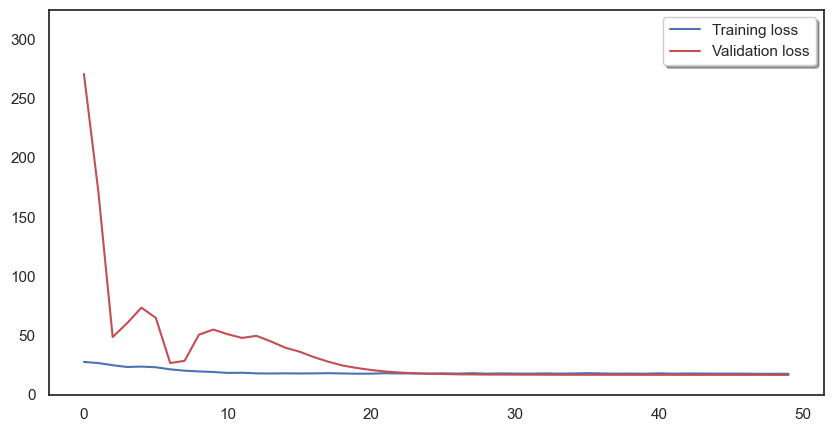

In [31]:
'''# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history1.history['loss'], color='b', label="Training loss")
ax.plot(history1.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history1.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)'''
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history1.history['loss'], color='b', label="Training loss")
ax.plot(history1.history['val_loss'], color='r', label="Validation loss")
ax.set_ylim(top=np.max(history1.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)


In [32]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model1.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_resnet = np.concatenate(all_labels)
cat_pred_resnet = np.concatenate(all_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


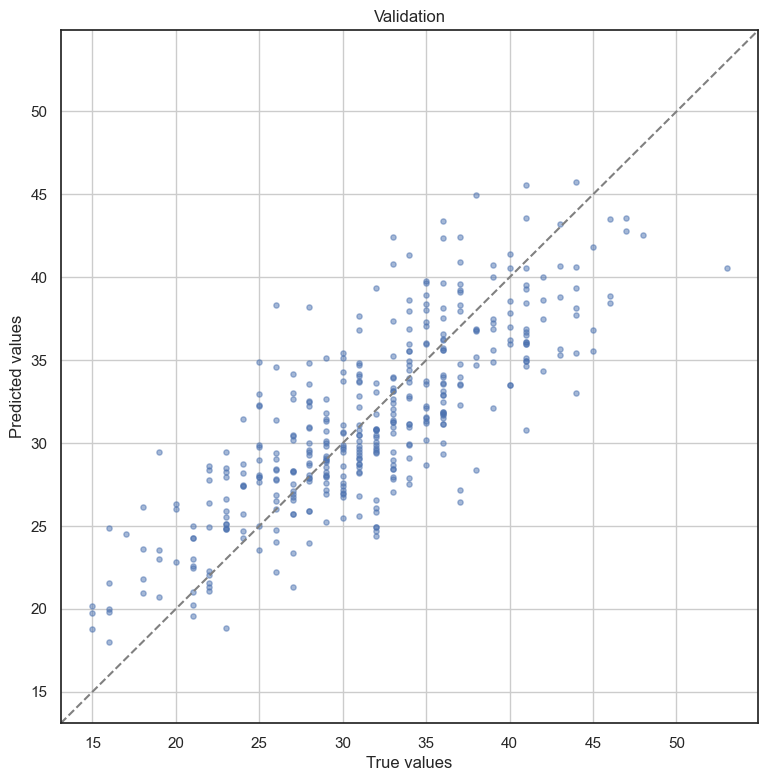

In [40]:

df_predictions_resnet = pd.DataFrame({'True values': cat_labels_resnet, 'Predicted values': cat_pred_resnet})
ax = df_predictions_resnet.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()
from tensorflow.keras.models import load_model

# Assuming `model` is your Keras model
model.save('model1.h5')


Loading image: archive/frames/frames/seq_000001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Loading image: archive/frames/frames/seq_000002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Loading image: archive/frames/frames/seq_000003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Loading image: archive/frames/frames/seq_000004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


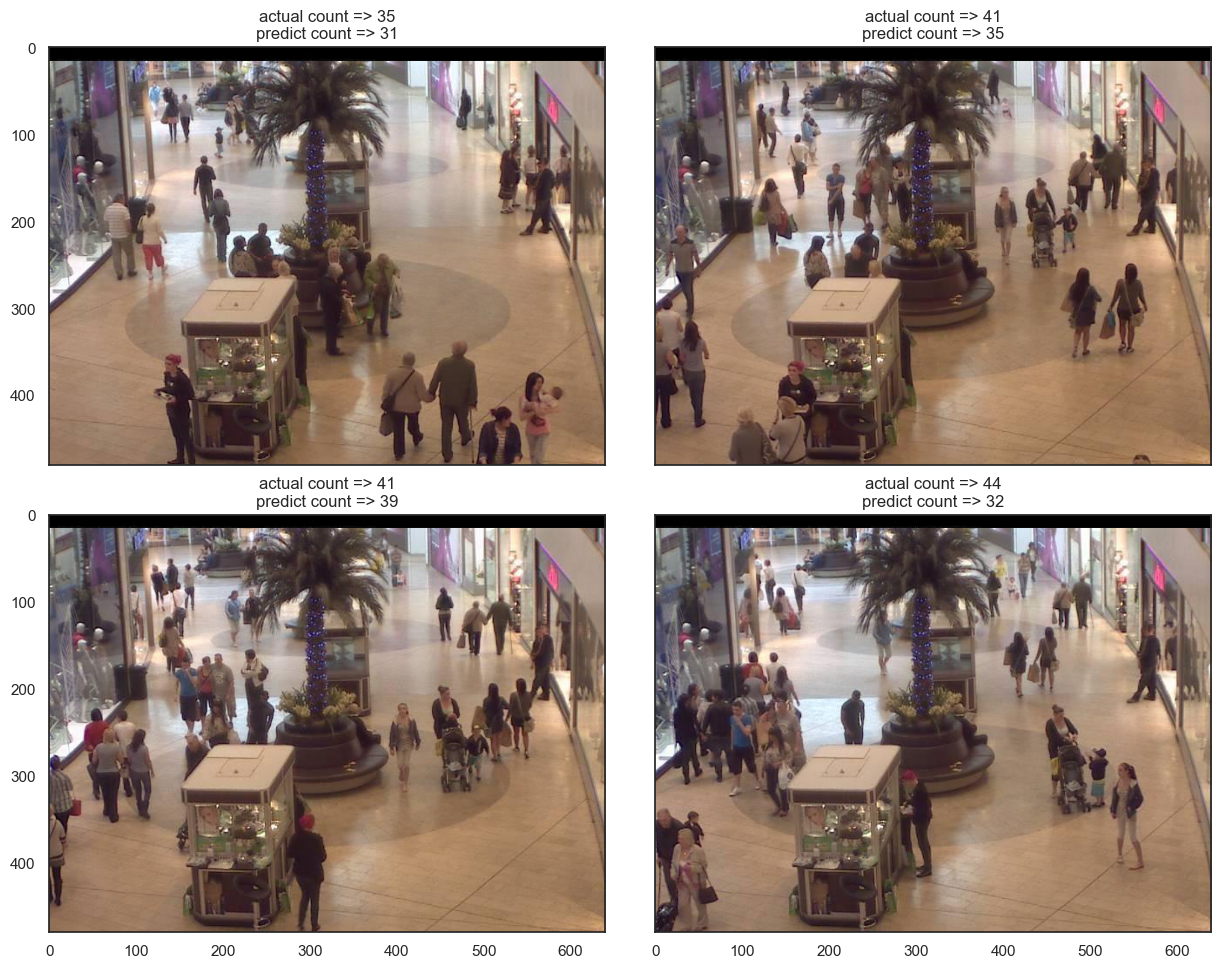

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
labels = np.array(df['count'])
# set figure size
img = np.load('/Users/dhevdharsan/Downloads/IOT_project/archive/images.npy')
fig = plt.figure(figsize=(15,15))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(2,2),
        axes_pad=0.5
)

# Load the pre-trained ResNet50 model
model = model1
for x in range(0, 4):
    image_path = 'archive/frames/frames/seq_00000%d.jpg' % (x+1)
    print("Loading image:", image_path)
    
    img1 = cv2.imread(image_path)

    if img1 is None:
        print("Failed to load image:", image_path)
        continue
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    m=img1
# Resize the image to the input size required by the model
    img1 = cv2.resize(img1, (224, 224))

# Scale the pixel values to be in the range of [0, 1]
    img1 = img1 / 255.0

# Expand the dimensions of the image to match the input shape required by the model
    img1 = np.expand_dims(img1, axis=0)

# Make a prediction on the image using the pre-trained model
    pred = model.predict(img1)

# The output of the model is a density map, so to get the actual count of people in the image,
# we need to sum up the pixel values in the density map and then round off to the nearest integer
    count = int(round(np.sum(pred)))
     
    title1 = 'actual count => ' + str(labels[x])
    title2 = 'predict count => ' + str(count)
    full_title = title1 + '\n' + title2
    grid[x].set_title(full_title)
      
    grid[x].imshow(img[x])
     

In [1]:
'''import cv2
import numpy as np
from pytube import YouTube
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your trained crowd density estimation model
model = load_model('model1.h5')

# Function to preprocess input frames
def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame / 255.0  # Normalize pixel values
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    return frame

# Function to estimate crowd density from a frame
def estimate_crowd_density(frame):
    preprocessed_frame = preprocess_frame(frame)
    density_map = model.predict(preprocessed_frame)
    crowd_count = int(np.sum(density_map))
    return crowd_count

# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=WvhYuDvH17I'

# Create a YouTube object
yt = YouTube(video_url)

# Choose the highest resolution stream
video_stream = yt.streams.get_highest_resolution()

# Open the video stream
cap = cv2.VideoCapture(video_stream.url)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    crowd_count = estimate_crowd_density(frame)

    # Display the crowd count on the frame
    cv2.putText(frame, f'Crowd Count: {crowd_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('Crowd Density Estimation', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()'''
import ssl

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context


import cv2
import numpy as np
from pytube import YouTube
from tensorflow.keras.models import load_model

# Load your trained crowd density estimation model
model = load_model('model1.h5')

# Function to preprocess input frames
def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame / 255.0  # Normalize pixel values
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    return frame

# Function to estimate crowd density from a frame
def estimate_crowd_density(frame):
    preprocessed_frame = preprocess_frame(frame)
    density_map = model.predict(preprocessed_frame)
    crowd_count = int(np.sum(density_map))
    return crowd_count

# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=WvhYuDvH17I'

# Create a YouTube object
yt = YouTube(video_url)

# Choose the highest resolution stream
video_stream = yt.streams.get_highest_resolution()

# Open the video stream
cap = cv2.VideoCapture(video_stream.url)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    crowd_count = estimate_crowd_density(frame)

    # Display the crowd count on the frame
    cv2.putText(frame, f'Crowd Count: {crowd_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('Crowd Density Estimation', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


2024-04-13 23:51:28.099 Python[8324:343529] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

[tls @ 0x298d27c40] Error in the pull function.
[tls @ 0x298d27c40] IO error: Connection reset by peer
[NULL @ 0x12865c3b0] Invalid NAL unit size (5827 > 5504).
[NULL @ 0x12865c3b0] missing picture in access unit with size 5508
[h264 @ 0x118652450] Invalid NAL unit size (5827 > 5504).
[h264 @ 0x118652450] Error splitting the input into NAL units.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x298d2edf0] stream 0, offset 0x1ca593: partial file


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


KeyboardInterrupt: 

: 

In [2]:
pip install numpy --upgrade

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.2 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.2 kB 217.9 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/61.2 kB 375.8 kB/s eta 0:00:01
     -------------------------------------- 61.2/61.2 kB 361.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.8 MB 3.2 MB/s eta 0:00:05
   ---------------------------------------- 0.1/15.8 MB 1.6 MB/s eta 0:00:10
    --------------------------------------- 0.2/15.8 MB 2.1 MB/s eta 0:00:08
   - -------------------------------------- 0.5/15.8 MB 3.0 MB/s eta 0:00:06
   -- ------------------------------------- 1.0/15.8 MB 4.7 MB/s eta 0:00:04
   ---- ----------------------------------- 1.7/15.8 MB 6.8 MB/s eta 0:00:03
   ------ --------------------------------- 2.8/15.8 MB 9.3 MB/s eta 0:00:02
   ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.6 requires aiohttp, which is not installed.
cupy-cuda113 10.6.0 requires numpy<1.25,>=1.18, but you have numpy 1.26.3 which is incompatible.


In [2]:
pip install pytube

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 330.3 kB/s eta 0:00:01
     --------------------------- ---------- 41.0/57.6 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 335.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
